<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/mlp_nr_v0_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Authored by

Miguel Fuentes-Cabrera, fuentescabma@ornl.gov

Center for Nanophase Materials Sciences

Oak Ridge National Laboratory


In [ ]:
# Import Python related required packages
import io
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Number of labels
nl = 3
#Number of epochs
num_epochs = 1600

In [ ]:
#Download dataloaders containing training, validation and test data for the MLP
!gdown "https://drive.google.com/uc?id=1zJPzEDRsqtJWtKKnaLAweNs2O2D3banH"
!gdown "https://drive.google.com/uc?id=1-44uc7wce6iyr-6jZqF_KvpyRT1U0E-_"
!gdown "https://drive.google.com/uc?id=1-0vJiyXciH_dycEwBAYj5pM5TVtTGfYI"
!gdown "https://drive.google.com/uc?id=11JUoHfBjRzCoWKldR42V3Jp7cbflPZG7"

Downloading...
From: https://drive.google.com/uc?id=1zJPzEDRsqtJWtKKnaLAweNs2O2D3banH
To: /content/mlp_train_loader.pth
100% 116k/116k [00:00<00:00, 59.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-44uc7wce6iyr-6jZqF_KvpyRT1U0E-_
To: /content/mlp_valid_loader.pth
100% 15.9k/15.9k [00:00<00:00, 17.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0vJiyXciH_dycEwBAYj5pM5TVtTGfYI
To: /content/mlp_test_loader.pth
100% 15.9k/15.9k [00:00<00:00, 17.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=11JUoHfBjRzCoWKldR42V3Jp7cbflPZG7
To: /content/mlp_test_dataset.pth
100% 15.3k/15.3k [00:00<00:00, 16.0MB/s]


In [ ]:
train_loader = torch.load('mlp_train_loader.pth')
valid_loader = torch.load('mlp_valid_loader.pth')
test_loader = torch.load('mlp_test_loader.pth')

test_dataset = torch.load('mlp_test_dataset.pth')

In [ ]:
#Defining a Multilayer Perceptron, MLP.
class MLP(nn.Module):

  def __init__(self,dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(d, 500),
      nn.ReLU(),
      nn.Linear(500, nl),
      # nn.ReLU(),
      # nn.Linear(32, nl),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
# from torch.optim import optimizer
### Define the loss function 
loss_fn = torch.nn.MSELoss()

### Define the learning rate
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model 
model = MLP(dim=d)
params_to_optimize = [
    {'params': model.parameters()}
]

#Define the optimizer
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

#Checking the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


In [ ]:
# Move model to device
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [ ]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = []
    for data,label in dataloader: 
        img = data
        img = img.to(device)
        # print(img.shape)
        label = label.to(device)
        out_label = model(img)
        loss = loss_fn(out_label, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Valid function
def valid_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            img = img.to(device)
            label = label.to(device)
            out_label = model(img)
            list_decoded_img.append(out_label.cpu())
            list_img.append(label.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img) 
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [ ]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
  val_loss = valid_epoch(model,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)


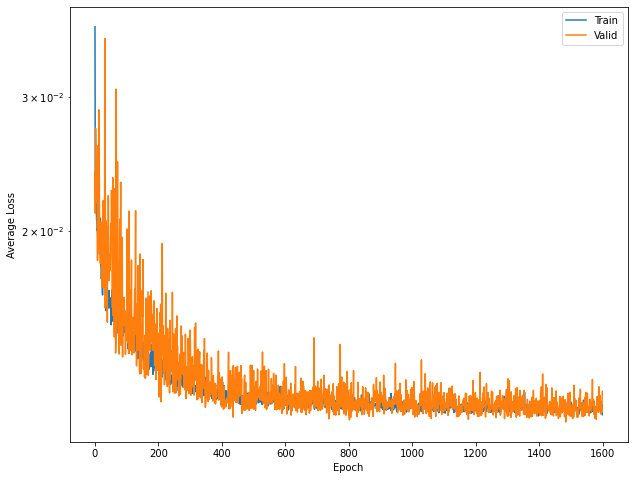

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
out_samples = []
for sample in test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nl):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples



,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.149972,-0.365494,-0.202298,0.17,-0.379,-0.19889
1,0.069622,0.257520,-0.405568,0.081,0.233,-0.41988
2,0.068979,0.473087,0.118361,0.0836,0.545,0.04137
3,0.107765,-0.367999,0.098013,0.104,-0.104,0.02657
4,0.151935,0.450645,0.162790,0.191,0.454,0.07949
...,...,...,...,...,...,...
590,0.145140,-0.304312,0.215359,0.146,-0.418,0.21433
591,0.122952,-0.277515,0.403790,0.106,-0.245,0.46617
592,0.144358,-0.266587,0.438049,0.129,-0.131,0.43445
593,0.083755,0.378526,-0.351444,0.0882,0.325,-0.23206


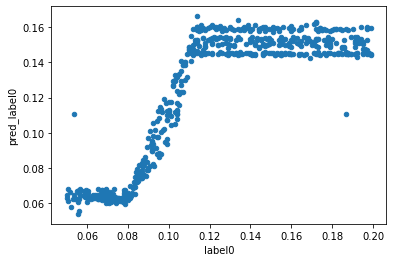

In [ ]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

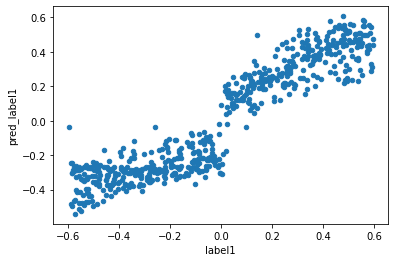

In [ ]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

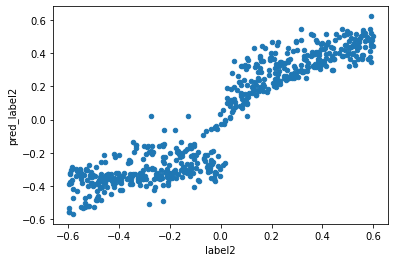

In [ ]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()